# Built In Beam in Bending

In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile, VTXWriter
import ufl
from dolfinx.io.gmshio import model_to_mesh
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime, timedelta
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client',port = 32802)
#pyvista.global_theme.trame.jupyter_extension_enabled = True

import gmsh
from ElasticPlasticity.Plastic_material import Plastic_Material
from ElasticPlasticity.Plastic_Visibility import Problem_Saver
from ElasticPlasticity.Plasticity_Funcs import *
from ElasticPlasticity.Plasticity_Problem import Plastic_Problem_Def

In [2]:
problem_name = "Hole In Plate"
# Geometric parameters
geom = dict(
        L0 = 15.0,   # Length mm
        W0 = 10.0,   # Width mm
        T0C = 1.0,    # Thickness mm
        )

# Mechanicals parameters
mech = {"E" : 200e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 100.0,  # MPa
        "H" : 1250.0, # MPa
        "r" : 1.0,
        "Y_s" :250.0,#mpa
        "C" : 60.0e3,
        "gamma":400.0
        
        }


# Study parameters
stud = {"deg_u" : 1,    # Interpolation of u
        "deg_strain_quad" : 2,  # Interpolation of sig, eps, p
        }


load_steps  = {
        "N_incr" : 60,  # Number of load steps
        "max_disp" : .01 # Maximal displacemen
        }


# Domain and Boundary Definition

In [3]:
gmsh.initialize()
gmsh.open("meshes/3D_hip_v2.geo")
points, lines, surfaces, volumes = [gmsh.model.getEntities(d) for d in [0, 1, 2, 3]]
gmsh.model.mesh.setSize(points, 1)  # heuristic
gmsh.model.occ.synchronize()
# Generate mesh
gmsh.model.mesh.generate(3)
gmsh.model.mesh.refine()
#gmsh.model.mesh.optimize("Netgen")
domain, ct, ft = model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0)
gmsh.finalize()

Info    : Reading 'meshes/3D_hip_v2.geo'...
Info    : Done reading 'meshes/3D_hip_v2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Circle)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 40%] Meshing curve 8 (Extruded)
Info    : [ 50%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 60%] Meshing curve 11 (Extruded)
Info    : [ 70%] Meshing curve 13 (Extruded)
Info    : [ 80%] Meshing curve 14 (Extruded)
Info    : [ 80%] Meshing curve 18 (Extruded)
Info    : [ 90%] Meshing curve 22 (Extruded)
Info    : [100%] Meshing curve 26 (Extruded)
Info    : Done meshing 1D (Wall 0.000282709s, CPU 0.000332s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 15 (Extruded)
Info    : [ 30%] Meshing surface 19 (Extrude

In [4]:
L0 = 15.0   # Length mm
W0 = 10.0   # Width mm
T0C = 1.0    # Thickness mm
x = ufl.SpatialCoordinate(domain)

In [5]:
np.unique(ft.values)

array([33, 34, 35], dtype=int32)

In [6]:
plotter = pyvista.Plotter()

num_local_cells = domain.topology.index_map(2).size_local

top = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,np.array(range(num_local_cells))) )
sides = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,ft.indices[ft.values==34]) )
bottom = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,ft.indices[ft.values==35]) )
arr = np.zeros(num_local_cells) 
arr[ft.indices] = ft.values
top.cell_data["Marker"] =arr


actor = plotter.add_mesh(top, show_edges=True)
actor2 = plotter.add_mesh(sides, show_edges=True,color="red")
actor3 = plotter.add_mesh(bottom, show_edges=True,color="green")
plotter.show_bounds(location='all')
plotter.show()

plotter.close()


Widget(value='<iframe src="http://localhost:46169/index.html?ui=P_0xffff6de49b40_0&reconnect=auto" class="pyvi…

In [7]:
sym_left_ft = 34
sym_top_ft = 33
bottom_ft = 35

## Visualize Geom

In [8]:
mat = Plastic_Material(domain = domain,**mech)
plastic_problem = Plastic_Problem_Def(domain,mat,facet_tags=ft,**stud)

# Boundary Conditions

In [9]:



top_facets = ft.find(sym_top_ft)
left_facets = ft.find(sym_left_ft)
bottom_facets = ft.find(bottom_ft)


fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)

disp = Constant(domain,(0.0,0.0,0.0))

bottom_dofs = fem.locate_dofs_topological(plastic_problem.V, fdim, bottom_facets)
top_dofs = fem.locate_dofs_topological(plastic_problem.V.sub(0), fdim, top_facets)
left_dofs = fem.locate_dofs_topological(plastic_problem.V.sub(1),fdim, left_facets)

top_disp = fem.dirichletbc(0.0, top_dofs, plastic_problem.V.sub(0)) 

sym_left = fem.dirichletbc(0.0, left_dofs, plastic_problem.V.sub(1))
bottom_clamp = fem.dirichletbc(disp, bottom_dofs, plastic_problem.V)#clamp x y and z

bcs = [top_disp,sym_left,bottom_clamp]

#bcs = [sym_bottom, sym_left]

#disp = Constant(domain,(0.0,0.0,0.0))


def F_ext(t):
    arr = np.zeros((3,))
    arr[1] = t*200.0
    return t*load_steps["max_disp"]

In [10]:
#plastic_problem._init_linear_problem([(-disp,plastic_problem.ds(2))])

# Data for Plotting

In [11]:
E_n = eps(plastic_problem.u)
E_p = plastic_problem.E_p

Stress_value = mat.sigma(E_n - E_p)
area= fem.form(1*plastic_problem.ds(bottom_ft))
area = fem.assemble_scalar(area)
Elastic = Function(plastic_problem.V_scal)

project(Stress_value[0,0],Elastic)
engineeringStress= fem.form(Elastic/area*plastic_problem.ds(bottom_ft)) #P22/area*ds


pointForStress = [0,geom["W0"]/2,geom["T0C"]/2]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [12]:
saver = Problem_Saver(plastic_problem,problem_name)


# Problem Solving

In [13]:
K = 60  # number of steps per load phase
Z = 2  # number of cycles
load, unload,load_2 = np.linspace(0.0, 1.0, num=K + 1), np.linspace(1.0, -1.0, num=K+ 1), np.linspace(-1.0, 1.0, num=K + 1)
cycle = np.concatenate((unload, load_2))
cycles = np.concatenate([load]+[cycle]*Z)
loads = cycles

In [14]:
startTime = datetime.now()
Nincr = load_steps["N_incr"]

results = np.zeros((len(cycles)+1, 4))
#F = np.vectorize(F_ext)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

#log.set_log_level(log.LogLevel.INFO)
saver.update_and_save(0)
for (i, load) in enumerate(loads):
    # Update Diriclet boundary condition
   
    disp.value =(F_ext(load),0.0,0.0)
    # Update the right hand side reusing the initial vector

    print("Increment:", str(i+1))
    niter = 0
    print("Linear Step 1 Start")
    plastic_problem.solve_linear(bcs) #Solves for the first trial displacement
    
    
    scal = fem.assemble_vector(plastic_problem.f_trial)
    print("Linear Step 1 Done")
    if scal.array.max() >= 0:
        error_0 = scal.array.max()
        niter = 0
        nls_ttime = timedelta(0,0,0)
        linear_ttime = timedelta(0,0,0)
        print("Starting Plastic Step")
        #while scal.array.max() >= 10 and niter < 20 and scal.array.max()/error_0 >.1:
           
           
        nls_time = datetime.now()
        plastic_problem.solve_nls()
        nls_ttime += datetime.now() - startTime
        linear_time = datetime.now()
        #print("Stop Plastic Step  Done")
        # print("Linear Step 2 Start")
        #f_trial = fem.assemble_scalar(fem.form(plastic_problem.res_p))
        #print(f_trial.norm())
    
        plastic_problem.solve_linear(bcs) #Solves for the actual displacement after the plastic update
        linear_ttime += datetime.now() - startTime
        plastic_problem.u.x.array[:] += plastic_problem.du.x.array[:]
        plastic_problem.u.x.scatter_forward()
        plastic_problem.du.x.array[:] = 0.0
        plastic_problem.dp.x.array[:] = 0.0
        plastic_problem.dp.x.scatter_forward()
        plastic_problem.du.x.scatter_forward()
        # print("Linear Step 2 Done")
        
        #scal = fem.assemble_vector(plastic_problem.f_trial)
        #print(scal.array.max())
        #niter +=1
       # print(f"Number of iterations: {niter}")
        print(f"Nonlinear time: {nls_ttime}")
        print(f"Linear time: {linear_ttime}")
    
    
    else:
        print("Skiping Plastic Step")
        
        #vec1 = fem.assemble_vector(fem.form(plastic_problem.res_p))
        #print(plastic_problem.du.x.array)
        plastic_problem.u.x.array[:] += plastic_problem.du.x.array[:]
        plastic_problem.du.x.array[:] = 0.0
        plastic_problem.dp.x.array[:] = 0.0
    
    
    project(Stress_value[0,0],Elastic)
    u_pointe = plastic_problem.u.eval(pointForStress,colliding_cells.array[0])[0]
    stress =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    #vec2 = fem.assemble_vector(fem.form(plastic_problem.res_p))
    #print(vec1.norm())
    #print(vec2.norm())
    results[i + 1, :] = (u_pointe,stress,i+1,F_ext(load))
    
    saver.update_and_save(i)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
saver.close()

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 2
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 3
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 4
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 5
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 6
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 7
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 8
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 9
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 10
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 11
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 12
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 13
Linear Step 1 St

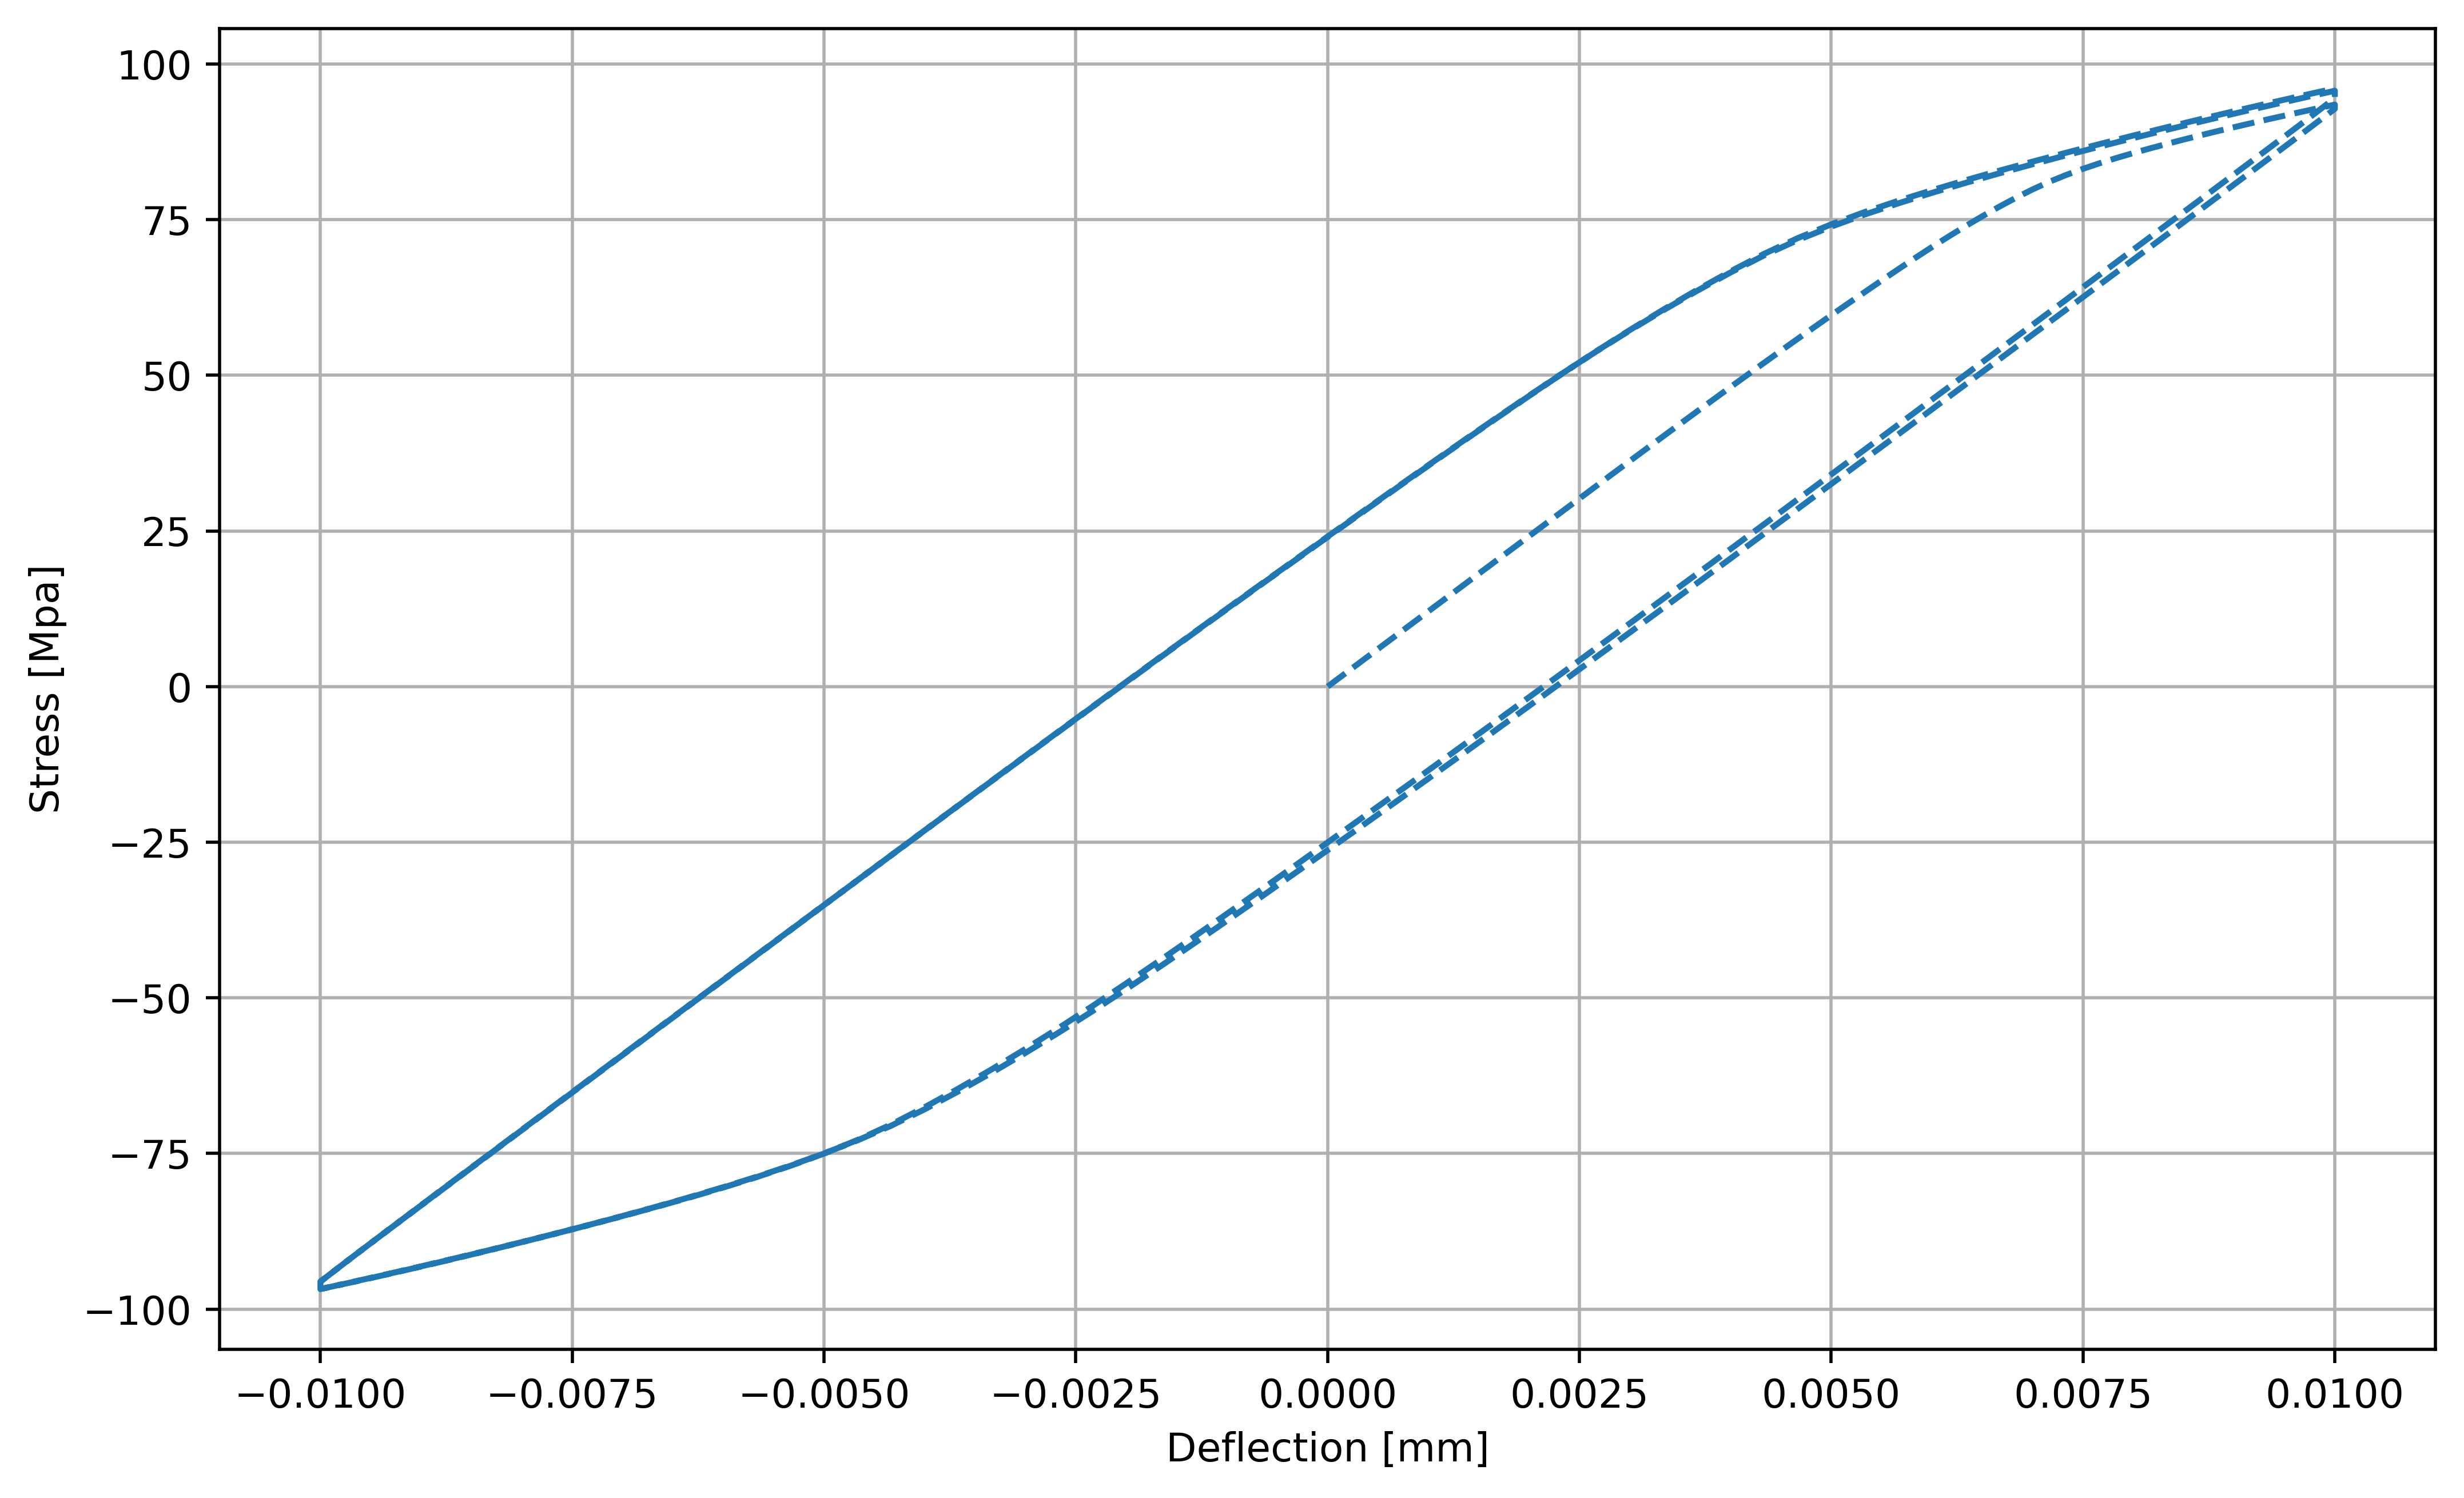

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=500)
plt.plot(results[0:500, 3], results[0:500, 1], "--")

#plt.plot(results[:, 0]/geom["longside"], results[:, 3], "-o")
plt.ylabel(r"Stress [Mpa]")
plt.xlabel(r"Deflection [mm]")
plt.grid()
plt.show()

In [16]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
import os

plt.rcParams["animation.ffmpeg_path"] = "/usr/bin/ffmpeg"


def plot_animation(
    colors, x, y, ylabel, xlabel
):
    fig = plt.figure()
    fig.set_size_inches(7, 5)

    def animate(i):
        plt.cla()

        plt.plot(x[0:i], y[0:i], '--',linewidth=1.5)
        plt.grid(linestyle="--", linewidth=0.5, color="b")
        
        axes = fig.get_axes()[0]
        axes.set_ylabel(ylabel)
        from matplotlib.ticker import AutoMinorLocator
        
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        axes.set_xlabel(xlabel)
        # ax2.plot(timeHist2[0:i], timeHist0[0:i], c=colors[0], linewidth=1.5)
        # ax2.grid(linestyle="--", linewidth=0.5, color="b")
        # ax2.set_xlabel("Time (s)")
        # ax2.set_ylabel(ylabel2)
        # from matplotlib.ticker import AutoMinorLocator

        # ax2.xaxis.set_minor_locator(AutoMinorLocator())
        # ax2.yaxis.set_minor_locator(AutoMinorLocator())

        axes.set_xlim(-.012, .012)
        axes.set_ylim(-105, 105)
        # ax2.set_ylim(-6.5, 6.6)

    set_fps = 24 
    ani = FuncAnimation(
        fig, animate, interval=1000 / set_fps, save_count=len(x)
    )
    

    f = r"media/Stress_Deflection_curve.mp4"
    
    if not os.path.exists('media'):
        os.makedirs('media')
    
    writervideo = FFMpegWriter(fps=set_fps)
    ani.save(f, writer=writervideo)

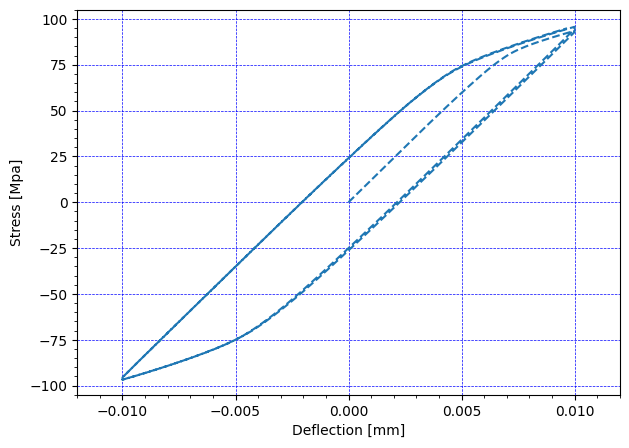

In [17]:
plot_animation(["blue","red","green","blue"], results[0:500, 3], results[0:500, 1],  r"Stress [Mpa]", r"Deflection [mm]")
